## 0. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from tqdm.notebook import tqdm

## 1. Set Up Constants

In [2]:
TEST_SIZE = 0.2
SEQUENCE_LENGTH = 14
RANDOM_STATE_SEED = 42

RSI_ROLLING_WINDOW_SIZE = 14

## 2. Original Dataset

#### Read Dataset

In [3]:
file_name = "SP500_forMacro.csv"

folder_name = "data"

folder_path = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(folder_path):
    
    dataset_file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(dataset_file_path, index_col=False)
    
    print(f"Dataset has been read from {dataset_file_path}.")

else:
    print(f"Folder {folder_name} is not found at {folder_path}.")

Dataset has been read from c:\Users\user\Documents\XIAMEN\Github Code Space\AML-Assignment\data\SP500_forMacro.csv.


#### Dataset Information and Summary

In [4]:
df.head()

,observation_date,SP500
0,2018-04-02,2581.88
1,2018-04-03,2614.45
2,2018-04-04,2644.69
3,2018-04-05,2662.84
4,2018-04-06,2604.47


In [5]:
df.tail()

,observation_date,SP500
1885,2025-06-23,6025.17
1886,2025-06-24,6092.18
1887,2025-06-25,6092.16
1888,2025-06-26,6141.02
1889,2025-06-27,6173.07


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  1890 non-null   object 
 1   SP500             1821 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.7+ KB


In [7]:
df.describe()

,SP500
count,1821.000000
mean,4018.773937
std,1003.013784
min,2237.400000
25%,3020.970000
50%,4006.180000
75%,4567.460000
max,6173.070000


## 3. Dataset Pre-Processing

#### Missing Value Check

In [8]:
df.isnull().sum()

observation_date     0
SP500               69
dtype: int64

In [9]:
df['SP500'] = df['SP500'].ffill()

In [10]:
df.isnull().sum()

observation_date    0
SP500               0
dtype: int64

In [11]:
df.describe()

,SP500
count,1890.000000
mean,4022.417037
std,1004.962205
min,2237.400000
25%,3024.420000
50%,4010.165000
75%,4573.537500
max,6173.070000


#### Set Index for Dataset

In [12]:
df['observation_date'] = pd.to_datetime(df['observation_date'])

df.set_index('observation_date', inplace=True)

In [13]:
df.head()

,SP500
observation_date,
2018-04-02,2581.88
2018-04-03,2614.45
2018-04-04,2644.69
2018-04-05,2662.84
2018-04-06,2604.47


#### Removing First 'RSI Rolling Window Size' Days of Data

In [14]:
df.head()

,SP500
observation_date,
2018-04-02,2581.88
2018-04-03,2614.45
2018-04-04,2644.69
2018-04-05,2662.84
2018-04-06,2604.47


In [15]:
# Dropout first n days of data due to missing data from GRU features (SMI)

df = df.iloc[(RSI_ROLLING_WINDOW_SIZE-1):]

#### Dataset Split

In [16]:
# Columns = 'SP500'
y = df['SP500']

# Columns = ['SP500', 'SMA_10', 'RSI', 'MACD']
X = df.copy(deep=True)

In [17]:
# Calculate starting index in the test dataset
start_idx = math.floor((1 - TEST_SIZE) * len(y))

# Obtain training and testing dataset for ARIMA
train_ARIMA = y[ :start_idx + SEQUENCE_LENGTH]
test_ARIMA = y[start_idx + SEQUENCE_LENGTH: ]

print(len(test_ARIMA))

362


## 4. Stationary Test

#### Plot SP500 Graph

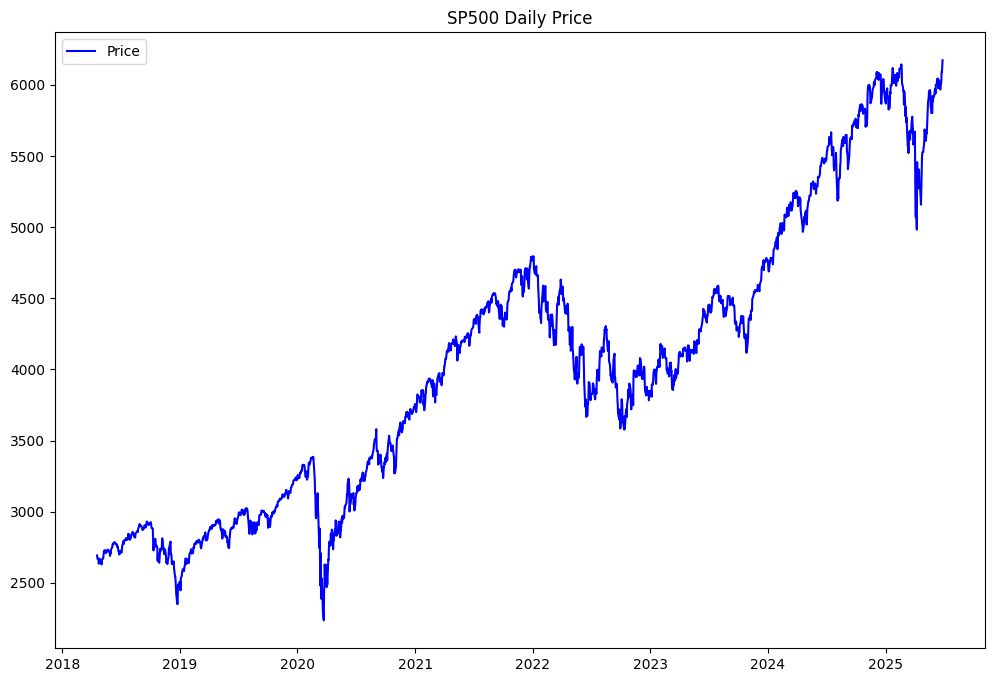

In [18]:
fig = plt.figure(figsize=(12, 8))

plt.plot(df['SP500'], color='blue', label='Price')

plt.title("SP500 Daily Price")
plt.legend()
plt.show()

#### Augmented Dickey-Fuller Test (ADF Test)

In [19]:
## For p-value

"""
Confidence level = 0.95

Alpha value --> 0.05

Null hypothesis     : Series is Non-stationary 
Alternate hypothesis: Series is Stationary 

Decision logic: Reject null hypothesis if p-value < alpha
"""

'\nConfidence level = 0.95\n\nAlpha value --> 0.05\n\nNull hypothesis     : Series is Non-stationary \nAlternate hypothesis: Series is Stationary \n\nDecision logic: Reject null hypothesis if p-value < alpha\n'

In [20]:
## For ADF statistics

"""
Alpha = 0.05

Decision Logic: If ADF statistics is lower than crtical value corresponding to alpha, reject null hypothesis
"""

'\nAlpha = 0.05\n\nDecision Logic: If ADF statistics is lower than crtical value corresponding to alpha, reject null hypothesis\n'

In [21]:
result = adfuller(df['SP500'])

#### Results Interpretation

In [22]:
# result[0] --> ADF statistics
print(f"ADF Statistics: {result[0]}")   

# result[1] --> p-value 
print(f"P-value: {result[1]}")

print("\nCritical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistics: -0.19084170734618847
P-value: 0.9396044934918389

Critical Values:
   1%: -3.433864939927475
   5%: -2.8630926485318433
   10%: -2.567596574226058


In [23]:
## For p-value

"""
p-value = 0.9396044934918389
alpha   = 0.05

Comparison: p-value > alpha

Decision logic: There is insufficient evidence to reject null hypothesis

Conclusion: This series data is non-stationary
"""

'\np-value = 0.9396044934918389\nalpha   = 0.05\n\nComparison: p-value > alpha\n\nDecision logic: There is insufficient evidence to reject null hypothesis\n\nConclusion: This series data is non-stationary\n'

In [24]:
## For ADF statistics

"""
ADF Statistics      = -0.19084170734618847
Critical Value (5%) = -2.8630926485318433

Comparison: ADF statistics > Critical value

Decision logic: There is insufficient evidence to reject null hypothesis

Conclusion: This series data is non-stationary
"""

'\nADF Statistics      = -0.19084170734618847\nCritical Value (5%) = -2.8630926485318433\n\nComparison: ADF statistics > Critical value\n\nDecision logic: There is insufficient evidence to reject null hypothesis\n\nConclusion: This series data is non-stationary\n'

## 5. Hyperparameters of ARIMA (p, d, q)

#### Find Non-Seasonal Differencing Order Parameter 'd'

In [25]:
first_diff_df = df['SP500'].diff().dropna()

second_diff_df = df['SP500'].diff().diff().dropna()

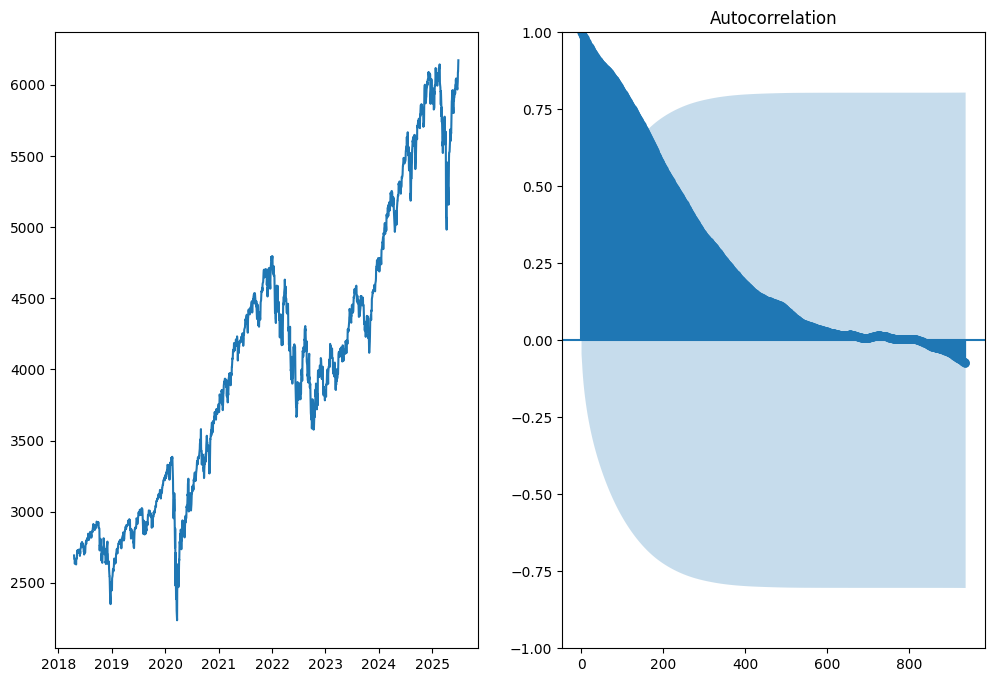

In [26]:
# Original Dataset

fig = plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(df['SP500'])

plot_acf(df['SP500'], ax=plt.subplot(1, 2, 2), lags = len(df['SP500'])/2)

plt.show()

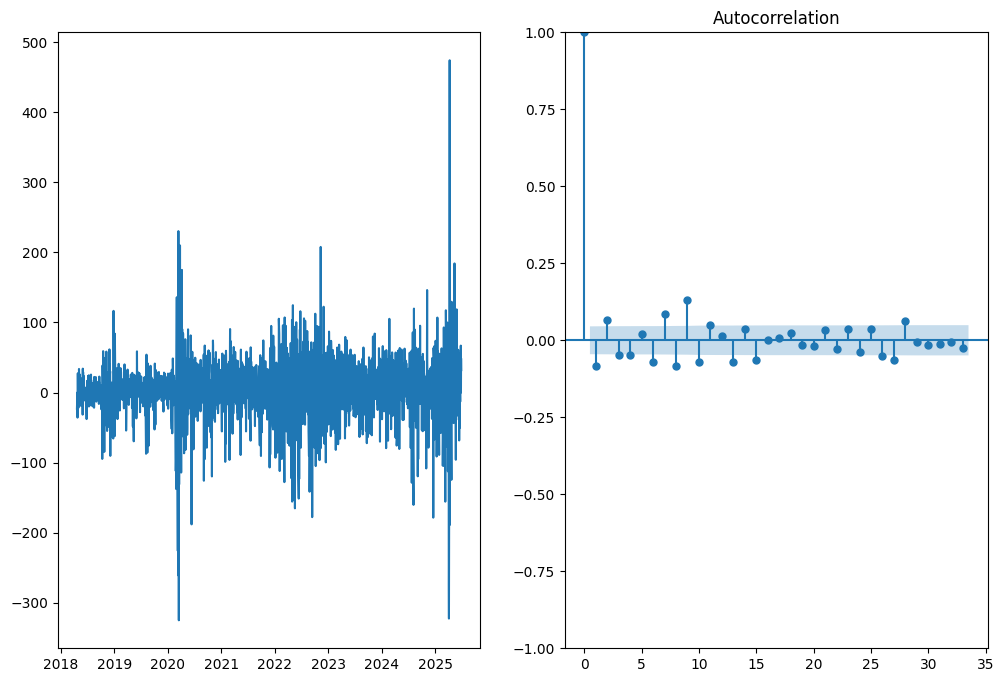

In [27]:
# First-Order Differencing Dataset

fig = plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(first_diff_df)

plot_acf(first_diff_df, ax=plt.subplot(1, 2, 2))

plt.show()

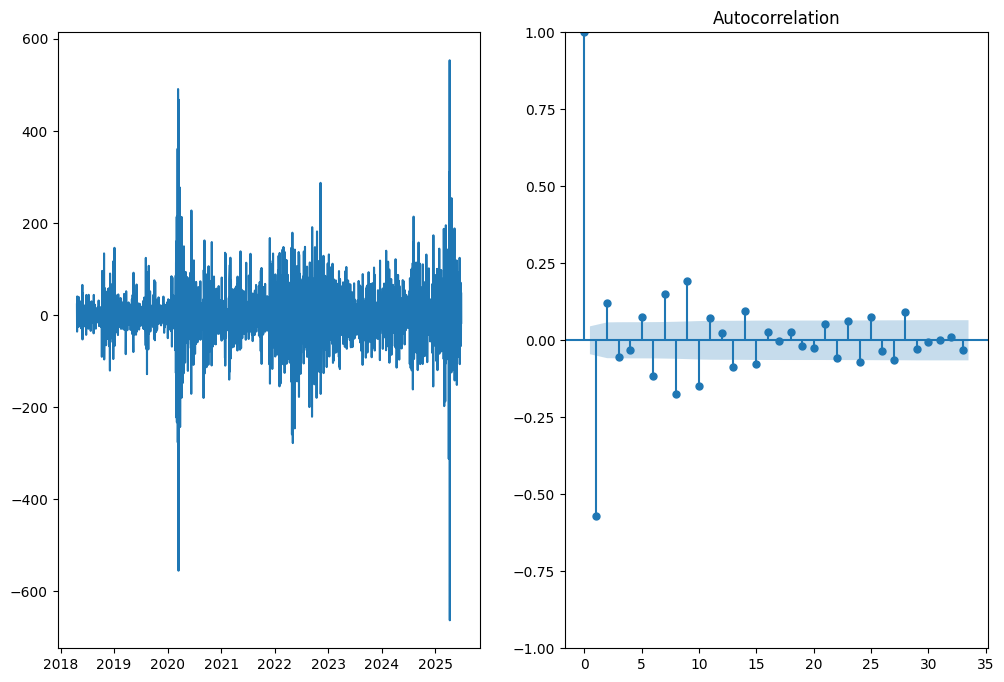

In [28]:
# Second-Order Differencing Dataset

fig = plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(second_diff_df)

plot_acf(second_diff_df, ax=plt.subplot(1, 2, 2))

plt.show()

In [29]:
"""
Pick d = 1 as in the second-order differencing dataset: 

- Lag 1 clearly went from not negatively-significant to very signficant lag
- This indicates an overdifferencing has occured when d = 2
- Hence, we will pick the previous value of d where d = 1
"""

'\nPick d = 1 as in the second-order differencing dataset: \n\n- Lag 1 clearly went from not negatively-significant to very signficant lag\n- This indicates an overdifferencing has occured when d = 2\n- Hence, we will pick the previous value of d where d = 1\n'

In [30]:
# Check to see if first-order differencing makes the series stationary

result = adfuller(first_diff_df)

# result[0] --> ADF statistics
print(f"ADF Statistics: {result[0]}")   

# result[1] --> p-value 
print(f"P-value: {result[1]}")

print("\nCritical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistics: -12.094102764805994
P-value: 2.0898364939452233e-22

Critical Values:
   1%: -3.433864939927475
   5%: -2.8630926485318433
   10%: -2.567596574226058


In [31]:
## For p-value

"""
p-value = 2.0898364939452233e-22
alpha = 0.05

Comparison: p-value < alpha

Decision logic: There is sufficient evidence to reject null hypothesis

Conclusion: This series data is stationary
"""

'\np-value = 2.0898364939452233e-22\nalpha = 0.05\n\nComparison: p-value < alpha\n\nDecision logic: There is sufficient evidence to reject null hypothesis\n\nConclusion: This series data is stationary\n'

In [32]:
## For ADF statistics

"""
ADF Statistics      = -12.094102764805994
Critical Value (5%) = -2.8630926485318433

Comparison: ADF statistics < Critical value

Decision logic: There is sufficient evidence to reject null hypothesis

Conclusion: This series data is stationary
"""

'\nADF Statistics      = -12.094102764805994\nCritical Value (5%) = -2.8630926485318433\n\nComparison: ADF statistics < Critical value\n\nDecision logic: There is sufficient evidence to reject null hypothesis\n\nConclusion: This series data is stationary\n'

In [33]:
d = 1

#### Find Non-Seasonal AR Parameter 'p'

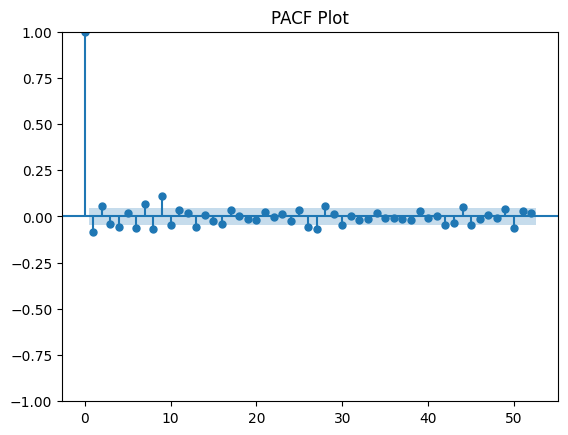

In [34]:
plot_pacf(first_diff_df, alpha=0.05, title="PACF Plot", lags=52)

plt.show()

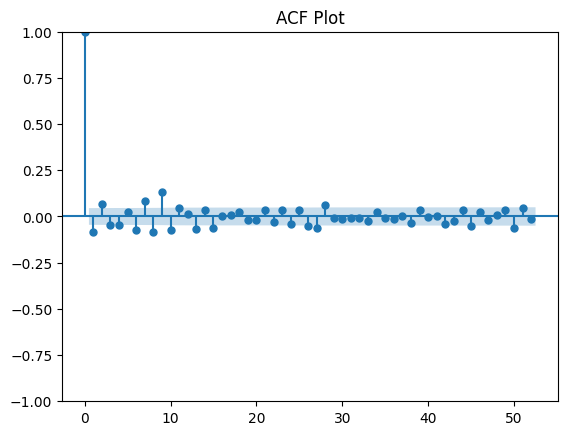

In [35]:
plot_acf(first_diff_df, alpha=0.05, title="ACF Plot", lags=52)

plt.show()

In [36]:
"""
From the PACF plot, we can see that:

Lag 1: First lag that is out of the significance limit boundary.

Lag 2: Not out of the signficance limit boundary by a lot.

This indicates after the significant lag 1, there is no more autoregressive (AR) structure.

Even through the ACF plot tails off after lag 9 but taking lag 9 as out AR term would produce too much insignificance consideration and burden the model's real prediction ability.

This conclusion is also supported that PACF plot after lag 1 quickly reverses to a insignificant lag.

AR term (p) = 1
"""

"\nFrom the PACF plot, we can see that:\n\nLag 1: First lag that is out of the significance limit boundary.\n\nLag 2: Not out of the signficance limit boundary by a lot.\n\nThis indicates after the significant lag 1, there is no more autoregressive (AR) structure.\n\nEven through the ACF plot tails off after lag 9 but taking lag 9 as out AR term would produce too much insignificance consideration and burden the model's real prediction ability.\n\nThis conclusion is also supported that PACF plot after lag 1 quickly reverses to a insignificant lag.\n\nAR term (p) = 1\n"

In [37]:
p = 1

#### Identify Non-Seasonal Parameter 'q'

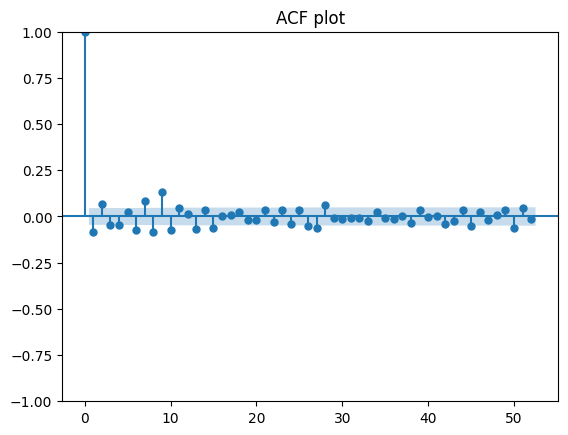

In [38]:
plot_acf(first_diff_df, alpha=0.05, title="ACF plot", lags=52)

plt.show()

In [39]:
"""
From the ACF plot, we can observe that --> 

Lag 0 is over the significance boundary.

After that, there are no more lags that cross the significance boundary.

This indcates that there are no dependence on current observation on any previous forecast errors.

As such, we shall pick q = 0.

MA term (q) = 0
"""

'\nFrom the ACF plot, we can observe that --> \n\nLag 0 is over the significance boundary.\n\nAfter that, there are no more lags that cross the significance boundary.\n\nThis indcates that there are no dependence on current observation on any previous forecast errors.\n\nAs such, we shall pick q = 0.\n\nMA term (q) = 0\n'

In [40]:
q = 0

## 6. ARIMA Model

#### Model Setup

In [41]:
model = ARIMA(train_ARIMA, order=(p, d, q))

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


#### Model Training

In [42]:
result = model.fit(method_kwargs={'maxiter': 1000})

#### Training Residuals

In [43]:
residuals = pd.DataFrame(result.resid)

In [44]:
residuals.describe()

,0
count,1515.000000
mean,3.446629
std,81.265804
min,-301.854353
25%,-16.406916
50%,2.513412
75%,23.410305
max,2693.130000


<Axes: title={'center': 'Residual Graph of ARIMA Dataset When Feed Full Dataset'}, xlabel='observation_date'>

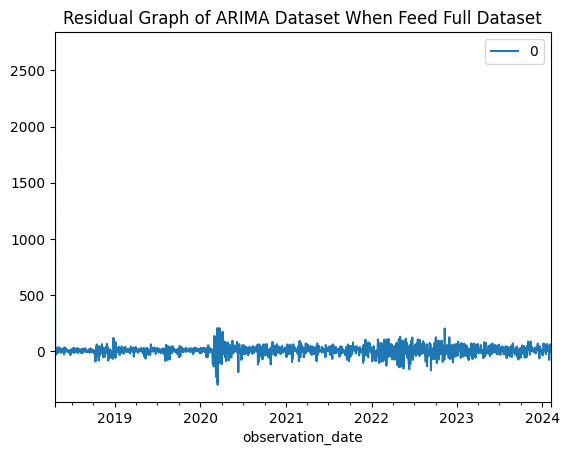

In [45]:
residuals.plot(title="Residual Graph of ARIMA Dataset When Feed Full Dataset")

<Axes: title={'center': 'Residual Density Graph'}, ylabel='Density'>

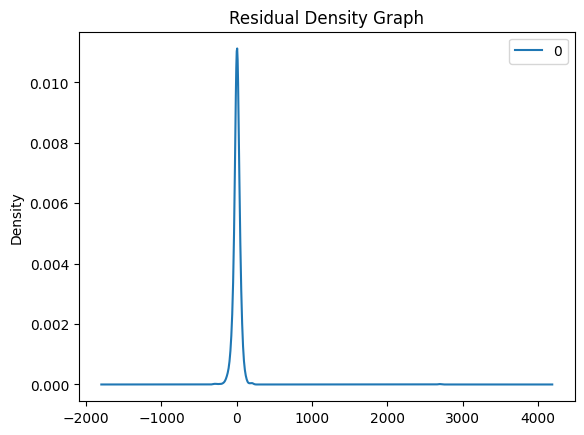

In [46]:
residuals.plot(kind='kde', title="Residual Density Graph")

#### Testing ARIMA Model

In [47]:
## Obtaining Error Value for Testing Dataset

arima_error_lst = []

test_pred_lst = []

history = [x for x in train_ARIMA]

for i in tqdm(range(0, len(test_ARIMA)), desc="Obtaining ARIMA Model error_lsts", leave=False):
    model = ARIMA(history,
                  order=(p, d, q))
    
    next_val = test_ARIMA[i]

    # Next training of ARIMA will include new value
    history.append(next_val)

    # Next training of ARIMA will discard earliest value to maintain window length
    history.pop(0)
    
    result = model.fit(method_kwargs={'maxiter': 1000})

    output = result.forecast(steps=1)

    # Output[0] --> Real value of prediction
    prediction = output[0]

    test_pred_lst.append(prediction)

    # Calculate error
    error = next_val - prediction

    arima_error_lst.append(error)

test_rmse = root_mean_squared_error(y_true=test_ARIMA,
                                    y_pred=test_pred_lst)

test_r2 = r2_score(y_true=test_ARIMA,
                   y_pred=test_pred_lst)

print(f'Test RMSE: {test_rmse:.3f}')

Obtaining ARIMA Model error_lsts:   0%|          | 0/362 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_17212\1938413583.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_val = test_ARIMA[i]


Test RMSE: 60.017


In [48]:
print(len(arima_error_lst))

362


#### Model Evaluation Metrics

In [49]:
test_rmse = root_mean_squared_error(y_true=test_ARIMA,
                                    y_pred=test_pred_lst)

print(f'Test RMSE: {test_rmse:.5f}')

Test RMSE: 60.01725


#### Graph of Prediction vs Real Data Graph 

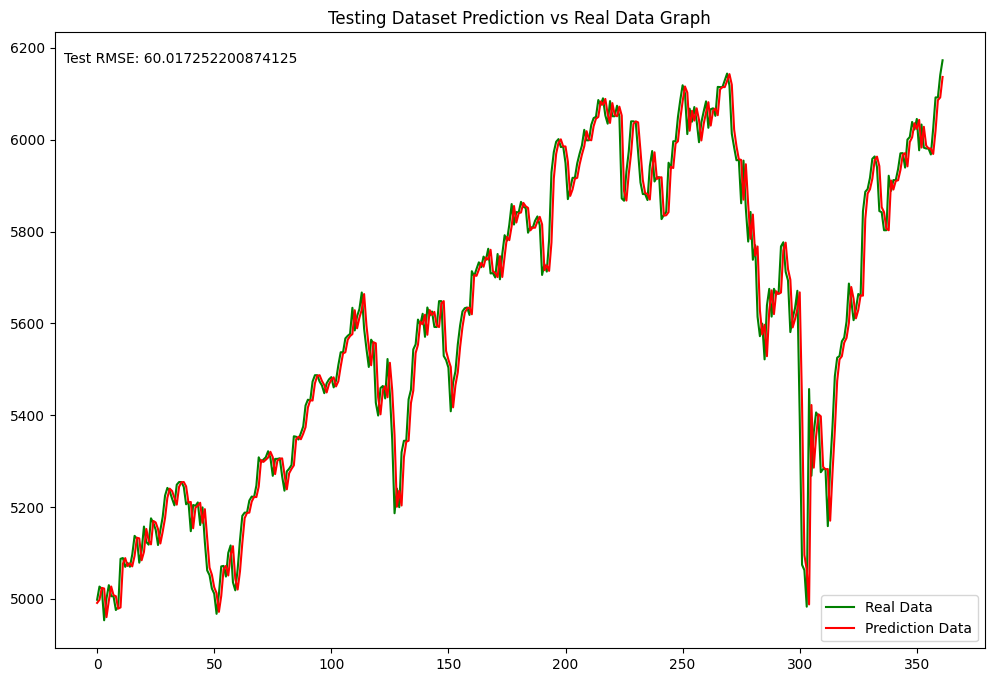

In [50]:
## For Testing Predictions

fig = plt.figure(figsize=(12,8))

plt.plot(test_ARIMA.to_list(), color='green', label='Real Data')
plt.plot(test_pred_lst, color='red', label='Prediction Data')

graph_title = "Testing Dataset Prediction vs Real Data Graph"

plt.text(
    x=0.01, y=0.95,
    s=f"Test RMSE: {test_rmse}",
    transform=plt.gca().transAxes,
    fontsize=10,
)

plt.title(graph_title)
plt.legend()    
plt.show()

## 6. Save ARIMA Error Prediction

In [51]:
arima_error_dic = {
    'Arima Error': arima_error_lst
}

arima_error_pd = pd.DataFrame(arima_error_dic)

folder_name = 'processed_data'

datafolder_filepath = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(datafolder_filepath) == False:
    os.mkdir(datafolder_filepath)
    print(f"Folder {folder_name} created.")

arima_error_filename = "arima_error.csv"

arima_error_filepath = os.path.join(os.getcwd(), folder_name, arima_error_filename)

arima_error_pd.to_csv(arima_error_filepath, index=False)

print(f"Arima prediction error file successfully saved at:\n{arima_error_filepath}\n")

Arima prediction error file successfully saved at:
c:\Users\user\Documents\XIAMEN\Github Code Space\AML-Assignment\processed_data\arima_error.csv

